In [1]:
import torch
import numpy as np
import os
import gpt as g
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
from qcd_ml.dirac import dirac_wilson_clover
from qcd_ml.nn.lptc import v_LPTC_NG
from qcd_ml.nn.ptc import v_PTC
from qcd_ml.dirac import dirac_wilson_clover

from stuff import *

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

In [54]:
class Smoother_PTC(torch.nn.Module):
    def __init__(self, U):
        super().__init__()
        self.U = U
        self.paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(mu, -1)] for mu in range(4)]
        self.l0 = v_PTC(2, 2, self.paths, self.U)
        self.l1 = v_PTC(2, 2, self.paths, self.U)
        self.l2 = v_PTC(2, 2, self.paths, self.U)
        self.l3 = v_PTC(2, 1, self.paths, self.U)

    def forward(self, v):
        for l in [self.l0, self.l1, self.l2, self.l3]:
            v = l.forward(v)
        return v

In [55]:
class Multigrid_Model(torch.nn.Module):
    def __init__(self, U, mg_setup):
        super().__init__()
        self.paths_coarse = [[]] + [[(mu, 1)] for mu in range(4)] + [[(3, -1)]]
        self.mg_setup = tuple(mg_setup)
        self.coarse_model = v_LPTC_NG(1, 1, self.paths_coarse, [2, 2, 2, 4], 4)
        self.smoother = Smoother_PTC(U)

    def forward(self, v):
        v1 = v
        v2 = torch.clone(v)
        v2_c = v_project(*self.mg_setup, v2[0])
        v2_c = self.coarse_model.forward(torch.stack([v2_c]))[0]
        v2 = v_prolong(*self.mg_setup, v2_c)
        return self.smoother.forward(torch.stack([v1[0], v2]))

In [56]:
mg_setup = torch.load("mg_setup.pt")
smoother_weights = torch.load("smoother_start_id.pt")
coarse_weights = torch.load("coarse.pt")

In [57]:
vec = torch.complex(
        torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
        , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))

In [58]:
model = Multigrid_Model(U, mg_setup)

for li, wi in zip([model.smoother.l0
                  , model.smoother.l1
                  , model.smoother.l2
                  , model.smoother.l3], smoother_weights):
    li.weights.data = wi

for wi in model.coarse_model.parameters():
    wi.requires_grad = False

In [59]:
U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.55,
    "csw_r": 0.0,
    "csw_t": 0.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))

GPT :  234294.906295 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :  234294.910977 s : Switching view to [1,1,1,1]/Read
GPT :  234294.933508 s : Read 0.00109863 GB at 0.0487428 GB/s (0.430172 GB/s for distribution, 0.0549815 GB/s for reading + checksum, 3.25884 GB/s for checksum, 1 views per node)
GPT :  234294.945614 s : Read 0.00109863 GB at 0.0973425 GB/s (3.31749 GB/s for distribution, 0.100313 GB/s for reading + checksum, 3.99653 GB/s for checksum, 1 views per node)
GPT :  234294.959474 s : Read 0.00109863 GB at 0.0834949 GB/s (3.24507 GB/s for distribution, 0.0857207 GB/s for reading + checksum, 3.29614 GB/s for checksum, 1 views per node)
GPT :  234294.971082 s : Read 0.00109863 GB at 0.108595 GB/s (4.07427 GB/s for distribution, 0.111609 GB/s for reading + checksum, 4.02445 GB/s for checksum, 1 views per node)
GPT :  234294.971825 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.0664198 s


  [ 1000|100.00%] <4.147e-02|  143>


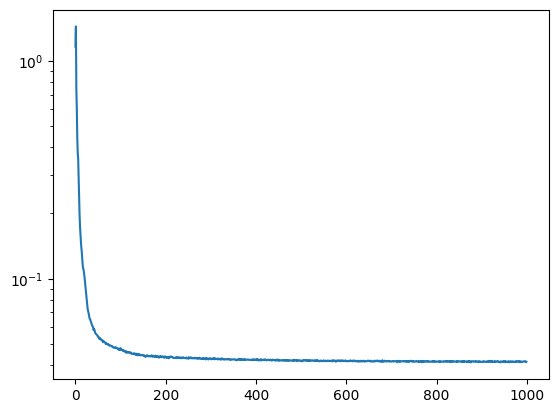

In [60]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
zero = torch.zeros_like(vec)

n_training = 1000
check_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    v1 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))
    v2 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

    Dinvv2, ret = GMRES_torch(w, v2, v2, eps=1e-3, maxiter=300)

    

    inp_before_norm = [w(v1), v2]
    norms = [norm(vi) for vi in inp_before_norm]
    
    inp = torch.stack([
        vi / ni for vi, ni in zip(inp_before_norm, norms)
    ])
    # FIXME
    outp = torch.stack([
        v1 / norms[0], Dinvv2 / norms[0]
    ])
    

    scale = l2norm(inp[0])
    inp = inp / scale
    outp = outp / scale
    
    score = complex_mse_loss(model.forward(inp), outp)
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_torch(w, vec, vec, prec=lambda v: model.forward(torch.stack([v, vec]))[0], eps=1e-4, maxiter=500)
    
        iterations_p[t // check_every - 1] = ret_p["k"]
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    
print()
plt.plot(loss)
plt.yscale("log")

Text(0, 0.5, 'iterations required by GMRES')

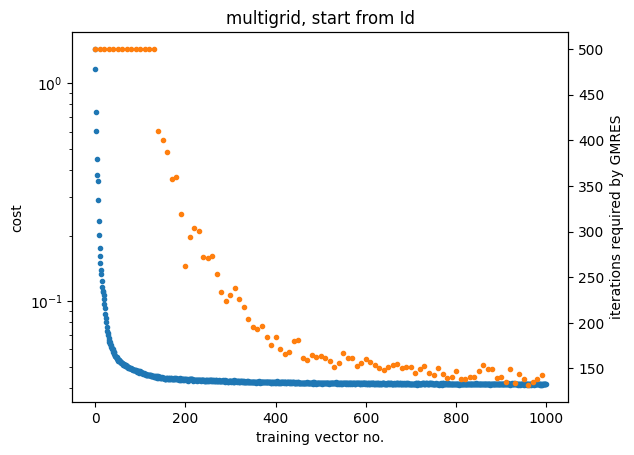

In [61]:
plt.plot(loss, ".")
plt.title("multigrid, start from Id")
plt.yscale("log")
plt.ylabel("cost")
plt.xlabel("training vector no.")
ax = plt.gca().twinx()
ax.plot(np.arange(0, n_training, check_every), iterations_p, "C1.")
ax.set_ylabel("iterations required by GMRES")

In [62]:
x, ret = GMRES_torch(w, vec, vec, eps=1e-4, maxiter=500)
ret

{'converged': True, 'k': 56, 'res': tensor(9.0657e-05, dtype=torch.float64)}

In [64]:
torch.save(model, "multigrid_model.01.pt")

  [ 1000|100.00%] <4.090e-02|   23>


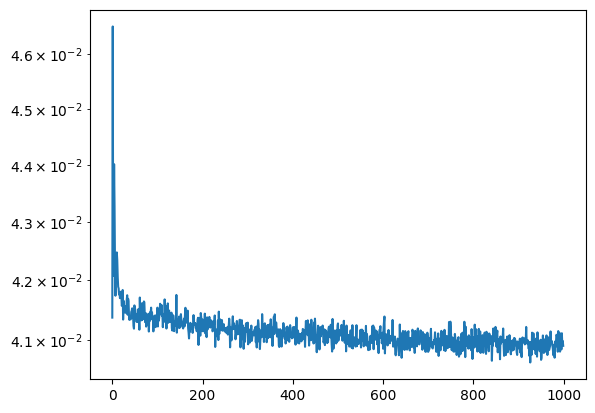

In [67]:
for wi in model.coarse_model.parameters():
    wi.requires_grad = True
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
zero = torch.zeros_like(vec)

n_training = 1000
check_every = 10

loss = np.zeros(n_training)
iterations_p = np.zeros(n_training // check_every)
ret_p = {"k": -1}

for t in range(1, n_training+1):
    v1 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))
    v2 = torch.complex(
            torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
            , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

    Dinvv2, ret = GMRES_torch(w, v2, v2, eps=1e-3, maxiter=300)

    

    inp_before_norm = [w(v1), v2]
    norms = [norm(vi) for vi in inp_before_norm]
    
    inp = torch.stack([
        vi / ni for vi, ni in zip(inp_before_norm, norms)
    ])
    # FIXME
    outp = torch.stack([
        v1 / norms[0], Dinvv2 / norms[0]
    ])
    

    scale = l2norm(inp[0])
    inp = inp / scale
    outp = outp / scale
    
    score = complex_mse_loss(model.forward(inp), outp)
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    if t % check_every == 0:
        print(f"G [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
        with torch.no_grad():
            x_p, ret_p = GMRES_torch(w, vec, vec, prec=lambda v: model.forward(torch.stack([v, vec]))[0], eps=1e-4, maxiter=500)
    
        iterations_p[t // check_every - 1] = ret_p["k"]
    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|{ret_p['k']:5d}>", end="\r")
    
print()
plt.plot(loss)
plt.yscale("log")

Text(0, 0.5, 'iterations required by GMRES')

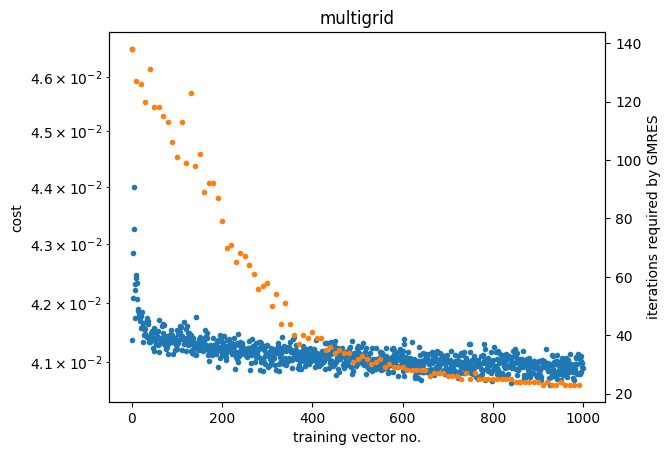

In [69]:
plt.plot(loss, ".")
plt.title("multigrid")
plt.yscale("log")
plt.ylabel("cost")
plt.xlabel("training vector no.")
ax = plt.gca().twinx()
ax.plot(np.arange(0, n_training, check_every), iterations_p, "C1.")
ax.set_ylabel("iterations required by GMRES")

In [70]:
torch.save(model, "multigrid_model.02.pt")
